In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Functions

In [2]:
def complex_soft_thresholding(x, T):
  eps = 1e-9
  return (np.abs(x) > T)*(np.abs(x) - T)*(x/np.abs(x+eps))

def complex_soft_thresholding_derivative(xHt, T):
  eps = 1e-9
  xr = np.real(xHt).flatten()
  xi = np.imag(xHt).flatten()
  den = (xr**2 + xi**2)**(3/2) + eps
  indicator = ((xr**2 + xi**2) > T**2).astype(float)
  
  dRdr = indicator*(1-T*xi**2/den)
  dIdi = indicator*(1-T*xr**2/den)

  return dRdr, dIdi

def eta(u, T, cmplx): # this can handle real and complex
# the thresholding function used in ISTA
  if cmplx:
    return np.exp(1j*np.angle(u)) * (np.maximum(np.abs(u)-T, 0))
  else:
      return (u - T)*(u >= T) + (u + T)*(u <= -T)

def onsager(z, r, tau):
# calculates and returns the onsager correction term
  n = len(z)
  return (z/n) * np.sum(eta(r, tau,cmplx) != 0)

def make_data(sys_param, tfs):
    # noise is boolean, true if noise
    # fading is boolean, true if fading; fading is real or complex depending on the value of cmplx
    # sigma is the variance of the noise given
    # dual_bs is a boolean, true for 2 BS case
    # cmplx is boolean, true if it wants complex values

    # returns A_1, A_2, x_uL, y_uL1, y_uL2, L1, L2
    # if it is a single base station then the unneeded values will be returned as zero

    # unwrap the arguments
    n, N, k, sigma = sys_param
    noise, fading, dual_bs, cmplx = tfs
    
    # always only makes one x-vector
    x_uL = np.zeros((N, 1), dtype=np.complex_)
    idx_nonzero_entries = np.random.permutation(N)[0:k]
    x_uL[idx_nonzero_entries] = 1

    # if there's two base stations, these values will be overridden
    A_2 = 0
    L2 = 0
    y_uL2 = 0

    if cmplx:  # complex single BS
        # sensing matrices
        A_1 = np.sqrt(1 / (2 * n)) * np.random.randn(n, N) + 1j * np.sqrt(1 / (2 * n)) * np.random.randn(n, N)
        # finding thresholding parameter
        _, Lambda1, _ = np.linalg.svd(A_1)
        L1 = np.max(Lambda1) + 1
        # creating complex noise
        w1 = np.sqrt((sigma ** 2) / 2) * np.random.randn(n).reshape(-1, 1) + 1j * np.sqrt(
            (sigma ** 2) / 2) * np.random.randn(n).reshape(-1, 1)

        if dual_bs:  # create second pair of matrices
            A_1 = np.sqrt(1 / (4 * n)) * np.random.randn(n, N) + 1j * np.sqrt(1 / (4 * n)) * np.random.randn(n, N)
            A_2 = A_1.copy()
            _, Lambda1, _ = np.linalg.svd(A_1)
            L1 = np.max(Lambda1) + 1
            L2 = L1
            w2 = np.sqrt((sigma ** 2) / 2) * np.random.randn(n).reshape(-1, 1) + 1j * np.sqrt(
                (sigma ** 2) / 2) * np.random.randn(n).reshape(-1, 1)

        if fading:  # complex fading
            # creating fading effects -> CN(0,1)
            h_uL1 = np.sqrt(1 / 2) * np.random.random(N) + np.sqrt(1 / 2) * 1j * np.random.random(N)
            h_uL1 = np.diag(h_uL1)
            # sensing matrix with fading applied
            A_1 = A_1 @ h_uL1
            # finding thresholding parameter
            _, Lambda1, _ = np.linalg.svd(A_1)
            L1 = np.max(Lambda1) + 1

            if noise:  # single BS, complex fading and noise
                y_uL1 = A_1 @ x_uL + w1
            else:
                y_uL1 = A_1 @ x_uL

            if dual_bs:  # complex fading, 2 BS
                # create second set of things
                # creating fading effects -> CN(0,1)
                h_uL2 = np.sqrt(1 / 2) * np.random.random(N) + np.sqrt(1 / 2) * 1j * np.random.random(N)
                h_uL2 = np.diag(h_uL2)
                # sensing matrix with fading applied
                A_2 = A_2 @ h_uL2
                # finding thresholding parameter
                _, Lambda1, _ = np.linalg.svd(A_2)
                L2 = np.max(Lambda1) + 1

                if noise:  # single BS, complex fading and noise
                    y_uL2 = A_2 @ x_uL + w2
                else:
                    y_uL2 = A_2 @ x_uL

        else:  # complex, no fading
            if noise:
                y_uL1 = A_1 @ x_uL + w1
            else:
                y_uL1 = A_1 @ x_uL

            if dual_bs:
                if noise:
                    y_uL2 = A_2 @ x_uL + w2
                else:
                    y_uL2 = A_2 @ x_uL

    else:  # real valued
        # sensing matrices
        A_1 = np.sqrt(1 / n) * np.random.randn(n, N)
        # finding thresholding parameter
        _, Lambda1, _ = np.linalg.svd(A_1)
        L1 = np.max(Lambda1) + 1
        # creating noise
        w1 = sigma * np.random.randn(n).reshape(-1, 1)

        if dual_bs:
            A_1 = np.sqrt(1 / (2*n)) * np.random.randn(n, N)
            A_2 = A_1.copy()
            _, Lambda1, _ = np.linalg.svd(A_1)
            L1 = np.max(Lambda1) + 1
            L2 = L1
            w2 = sigma * np.random.randn(n).reshape(-1, 1)

        if fading:  # real valued, 1 BS fading
            # creating fading effects -> N(0,1)
            h_uL1 = np.random.rayleigh(size=N)
            h_uL1 = np.diag(h_uL1)
            # sensing matrix with fading applied
            A_1 = A_1 @ h_uL1
            # finding thresholding parameter
            _, Lambda1, _ = np.linalg.svd(A_1)
            L1 = np.max(Lambda1) + 1

            if noise:
                y_uL1 = A_1 @ x_uL + w1
            else:
                y_uL1 = A_1 @ x_uL

            if dual_bs:
                # creating fading effects -> CN(0,1)
                h_uL2 = np.random.rayleigh(size=N)
                h_uL2 = np.diag(h_uL2)
                # sensing matrix with fading applied
                A_2 = A_2 @ h_uL2
                # finding thresholding parameter
                _, Lambda1, _ = np.linalg.svd(A_2)
                L2 = np.max(Lambda1) + 1
                if noise:
                    y_uL2 = A_2 @ x_uL + w1
                else:
                    y_uL2 = A_2 @ x_uL

        else:  # no fading, real values
            if noise:
                y_uL1 = A_1 @ x_uL + w1
            else:
                y_uL1 = A_1 @ x_uL

            if dual_bs:
                if noise:
                    y_uL2 = A_2 @ x_uL + w2
                else:
                    y_uL2 = A_2 @ x_uL

    return A_1, A_2, x_uL, y_uL1, y_uL2, L1, L2

In [3]:
def amp_mse_iter(sys_param, tfs, num_iterations, avg): 
# sys_param holds n,N,k vals and sigma
# tfs (true-falses) holds system information
# returns the MSE per iterations

    n,N,k,sigma = sys_param
    noise, fading, dual_bs, cmplx = tfs

    mse_per_iteration = np.zeros(num_iterations)

    for j in range(avg):
      A1, A2, x_uL, y_uL1, y_uL2, L1, L2 = make_data(sys_param, tfs)  # make the data needed

      if dual_bs: # concatenate the necessary vectors then proceed
          # you could probably work this into the make_data function
          A1 = np.vstack((A1,A2))
          y_uL1 = np.vstack((y_uL1,y_uL2))
      
      if cmplx: # run complex AMP
          xHt = np.zeros(x_uL.shape, dtype=np.complex_)
          z = y_uL1 - (A1@xHt)

          for idxit in range(num_iterations):
            r = A1.conj().T @ z + xHt
            sigma_hat = 1/np.sqrt(np.log(2))*np.median(np.abs(r))
            xHt = complex_soft_thresholding(r, sigma_hat)
            etaderR, etaderI = complex_soft_thresholding_derivative(r, sigma_hat);
            z = y_uL1 - A1@xHt + z*(np.sum(etaderR)+np.sum(etaderI))/(2*n);
            mse_per_iteration[idxit] += np.linalg.norm(xHt.flatten() - x_uL.flatten())**2 / N
          
      
      else: # run normal AMP
          z = np.zeros(y_uL1.shape)
          xHt = np.zeros(x_uL.shape)
          r = 0
          tau = 0
          ons = 0

          # based on equation described in Background section
          for idx_iter in range(num_iterations):
              ons = onsager(z, r, tau)
              z = y_uL1 - A1 @ xHt + ons
              if dual_bs:
                tau = np.sqrt(1/(2*n)) * np.linalg.norm(z)
              else:
                tau = np.sqrt(1/n) * np.linalg.norm(z)              
              r = xHt + A1.T @ z
              xHt = eta(r, tau, cmplx)

              # find the current error
              mse_per_iteration[idx_iter] += (1/N) * np.sum(abs(x_uL - xHt)**2)
    
    # average out the result
    return mse_per_iteration / avg

In [4]:
def amp_mse_snr(sys_param, tfs, num_iterations, avg):
# sys_param holds n,N,k vals and sigma
# tfs (true-falses) holds system information
# returns the MSE for some SNRs
    alpha = .25  # predetermined for the 1 BS case
    n,N,k,sigma = sys_param
    noise, fading, dual_bs, cmplx = tfs

    # creating noise matrix
    SNRdB = np.array([-12,-10, -5, 1, 5, 10, 20])
    if dual_bs:
      SNRs = (10**(SNRdB/10))*2*n
    else:
      SNRs = (10**(SNRdB/10))*n
    sigmas = 1/(np.sqrt(SNRs))
    
    mse_snr = np.zeros(len(sigmas))

    cnt = 0
    for sig in sigmas:
      mse = 0
      for i in range(avg):
        sys_param = (n,N,k,sig)
        A1, A2, x_uL, y_uL1, y_uL2, L1, L2 = make_data(sys_param, tfs)  # make the data needed

        if dual_bs: # concatenate the necessary vectors then proceed
          # you could probably work this into the make_data function
          A1 = np.vstack((A1,A2))
          y_uL1 = np.vstack((y_uL1,y_uL2))

        if cmplx: # run complex AMP
            xHt = np.zeros(x_uL.shape, dtype=np.complex_)
            z = y_uL1 - (A1@xHt)

            for idxit in range(num_iterations):
              r = A1.conj().T @ z + xHt
              sigma_hat = 1/np.sqrt(np.log(2))*np.median(np.abs(r))
              xHt = complex_soft_thresholding(r, sigma_hat)
              etaderR, etaderI = complex_soft_thresholding_derivative(r, sigma_hat);
              z = y_uL1 - A1@xHt + z*(np.sum(etaderR)+np.sum(etaderI))/(2*n);
            mse_snr[cnt] += np.linalg.norm(xHt.flatten() - x_uL.flatten())**2 / N
            
        
        else: # run normal AMP
            z = np.zeros(y_uL1.shape)
            xHt = np.zeros(x_uL.shape)
            r = 0
            tau = 0
            ons = 0

            for idx_iter in range(num_iterations):
                ons = onsager(z, r, tau)
                z = y_uL1 - A1 @ xHt + ons
                if dual_bs:
                  tau = np.sqrt(1/(2*n)) * np.linalg.norm(z)
                else:
                  tau = np.sqrt(1/n) * np.linalg.norm(z) 
                r = xHt + A1.T @ z
                xHt = eta(r, tau, cmplx)
            # find the current error
            mse_snr[cnt] += (1/N) * np.sum((x_uL - xHt)**2)
  
      cnt+=1 
    return mse_snr / avg

In [5]:
def amp_md_fa_iter(sys_param, tfs, num_iterations, avg, threshold):
    # unwrap the input tuples
    n,N,k,sigma = sys_param
    noise, fading, dual_bs, cmplx = tfs
    
    fa_iter = np.zeros(num_iterations)
    md_iter = np.zeros(num_iterations)

    for j in range(avg):
      # create new data
      A1, A2, x_uL, y_uL1, y_uL2, L1, L2 = make_data(sys_param, tfs)

      # find active users
      real_users = np.where(x_uL == 1)[0]

      if dual_bs: # concatenate the necessary vectors then proceed
          A1 = np.vstack((A1,A2))
          y_uL1 = np.vstack((y_uL1,y_uL2))
      
      if cmplx: # run complex AMP
          xHt = np.zeros(x_uL.shape, dtype=np.complex_)
          z = y_uL1 - (A1@xHt)

          for idxit in range(num_iterations):
            r = A1.conj().T @ z + xHt
            sigma_hat = 1/np.sqrt(np.log(2))*np.median(np.abs(r))
            xHt = complex_soft_thresholding(r, sigma_hat)
            etaderR, etaderI = complex_soft_thresholding_derivative(r, sigma_hat);
            z = y_uL1 - A1@xHt + z*(np.sum(etaderR)+np.sum(etaderI))/(2*n);
            # find detection errors
            xHt_user_guess = np.where(abs(xHt) > threshold)[0]
            fa = np.setdiff1d(xHt_user_guess, real_users)  # returns the guessed values that aren't in real ones. aka False Alarm
            md = np.setdiff1d(real_users, xHt_user_guess)  # real values that aren't in the guessed ones. aka Misdetection

            fa_iter[idxit] += len(fa)
            md_iter[idxit] += len(md)
      
      else: # run normal AMP
          z = np.zeros(y_uL1.shape)
          xHt = np.zeros(x_uL.shape)
          r = 0
          tau = 0
          ons = 0

          # based on equation described in Background section
          for idx_iter in range(num_iterations):
            ons = onsager(z, r, tau)
            z = y_uL1 - A1 @ xHt + ons
            if dual_bs:
              tau = np.sqrt(1/(2*n)) * np.linalg.norm(z)
            else:
              tau = np.sqrt(1/n) * np.linalg.norm(z) 
            r = xHt + A1.T @ z
            xHt = eta(r, tau, cmplx)

            # find detection errors
            xHt_user_guess = np.where(abs(xHt) > threshold)[0]
            fa = np.setdiff1d(xHt_user_guess, real_users)  # returns the guessed values that aren't in real ones. aka False Alarm
            md = np.setdiff1d(real_users, xHt_user_guess)  # real values that aren't in the guessed ones. aka Misdetection

            fa_iter[idx_iter] += len(fa)
            md_iter[idx_iter] += len(md)
    # average out the result
    return md_iter / avg, fa_iter / avg

In [6]:
def amp_md_fa_snr(sys_param, tfs, num_iterations, avg, threshold):
  # unwrap parameters
  n,N,k,sigma = sys_param
  noise, fading, dual_bs, cmplx = tfs

 # creating noise matrix
  SNRdB = np.array([-12,-10, -5, 1, 5, 10, 20])
  if dual_bs:
    SNRs = (10**(SNRdB/10))*2*n
  else:
    SNRs = (10**(SNRdB/10))*n
  sigmas = 1/(np.sqrt(SNRs))

  fa_snr = np.zeros(len(sigmas))
  md_snr = np.zeros(len(sigmas))

  cnt = 0 
  for sig in sigmas:
    for j in range(avg):
      # create new data
      sys_param = (n,N,k,sig)
      A1, A2, x_uL, y_uL1, y_uL2, L1, L2 = make_data(sys_param, tfs)
      real_users = np.where(x_uL == 1)[0]

      if dual_bs: # concatenate the necessary vectors then proceed
          # you could probably work this into the make_data function
          A1 = np.vstack((A1,A2))
          y_uL1 = np.vstack((y_uL1,y_uL2))

      if cmplx: # run complex AMP
          xHt = np.zeros(x_uL.shape, dtype=np.complex_)
          z = y_uL1 - (A1@xHt)

          for idxit in range(num_iterations):
            r = A1.conj().T @ z + xHt
            sigma_hat = 1/np.sqrt(np.log(2))*np.median(np.abs(r))
            xHt = complex_soft_thresholding(r, sigma_hat)
            etaderR, etaderI = complex_soft_thresholding_derivative(r, sigma_hat);
            z = y_uL1 - A1@xHt + z*(np.sum(etaderR)+np.sum(etaderI))/(2*n);
          # find detection errors
          xHt_user_guess = np.where(abs(xHt) > threshold)[0]
          fa = np.setdiff1d(xHt_user_guess, real_users)  # returns the guessed values that aren't in real ones. aka False Alarm
          md = np.setdiff1d(real_users, xHt_user_guess)  # real values that aren't in the guessed ones. aka Misdetection
          fa_snr[cnt] += len(fa)
          md_snr[cnt] += len(md)
      
      else: # run normal AMP
          z = np.zeros(y_uL1.shape)
          xHt = np.zeros(x_uL.shape)
          r = 0
          tau = 0
          ons = 0

          for idx_iter in range(num_iterations):
              ons = onsager(z, r, tau)
              z = y_uL1 - A1 @ xHt + ons
              if dual_bs:
                tau = np.sqrt(1/(2*n)) * np.linalg.norm(z)
              else:
                tau = np.sqrt(1/n) * np.linalg.norm(z) 
              r = xHt + A1.T @ z
              xHt = eta(r, tau, cmplx)
          # find detection errors
          xHt_user_guess = np.where(abs(xHt) > threshold)[0]
          fa = np.setdiff1d(xHt_user_guess, real_users)  # returns the guessed values that aren't in real ones. aka False Alarm
          md = np.setdiff1d(real_users, xHt_user_guess)  # real values that aren't in the guessed ones. aka Misdetection
          fa_snr[cnt] += len(fa)
          md_snr[cnt] += len(md)
    cnt+=1 

    # print('*************************')
    # print(f'var: {sigma}')
    # for idx in xHt_user_guess:
    #   print(f'xHt: {abs(xHt[idx])}')
    #   print(f'x: {abs(x_uL[idx])}')

  return md_snr / avg, fa_snr / avg


# Undersampling and sparsity ratio

In [ ]:
k = 40
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
original = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(original, separator=','))

[0.02837921,0.02515599,0.02197906,0.01958064,0.01767352,0.01628073,
 0.01510869,0.01408144,0.0133708 ,0.01260917,0.01204209,0.01156677,
 0.01118349,0.01080638,0.01038322]


In [ ]:
k = 40*10
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
ten = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(ten, separator=','))

[0.33746252,0.35305445,0.35983764,0.36585554,0.36784536,0.37172628,
 0.37566554,0.38053545,0.38119988,0.38080673,0.38096043,0.37974686,
 0.37815593,0.37841944,0.37804041]


In [ ]:
# n/N = .263
# k/N = .078

# double the sparsity!
k = 40*2
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
sys_param = (n,N,k,sigma)
double_sparse = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(double_sparse, separator=','))

[0.05868067,0.05461918,0.04919712,0.04595101,0.04294404,0.04079232,
 0.0389443 ,0.03720814,0.03588712,0.03456279,0.03353476,0.03265828,
 0.03200164,0.03119624,0.03061968]


In [ ]:
# n/N = .263
# k/N = .019

# half the sparsity!
k = int(40/2)
N = 1024
n = 270

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
sys_param = (n,N,k,sigma)
half_sparse = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(half_sparse, separator=','))

[0.01324346,0.01131945,0.00936138,0.0081801 ,0.00712816,0.00630427,
 0.00576401,0.0052637 ,0.00492213,0.00462258,0.00436481,0.00414685,
 0.00398237,0.00384496,0.00374317]


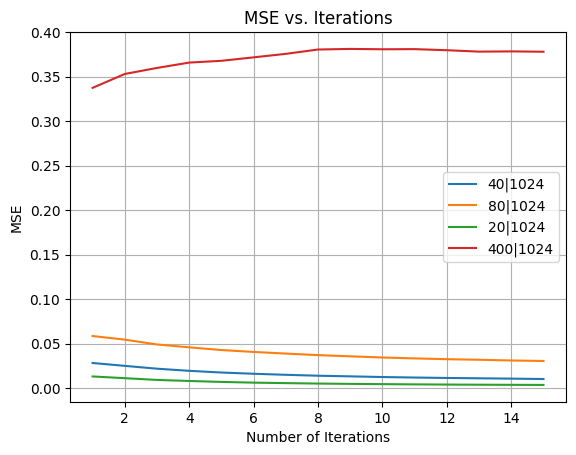

In [ ]:
plt.figure()
plt.plot(range(1,16), original, label='40|1024')
plt.plot(range(1,16), double_sparse, label='80|1024')
plt.plot(range(1,16), half_sparse, label='20|1024')
plt.plot(range(1,16), ten, label='400|1024')
plt.grid(True, which='both')
plt.legend()
plt.xlabel("Number of Iterations")
plt.title("MSE vs. Iterations")
plt.ylabel("MSE")
plt.show()

In [ ]:
# n/N = .1318
# k/N = .029
# multiply everything by 3 and see if you get the same results
k = 40*3
N = 1024*4
n = 270*2

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
sys_param = (n,N,k,sigma)
diff_ratio = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(diff_ratio, separator=','))

[2.37209013e-02,3.56135347e-02,5.63001274e-02,9.35475523e-02,
 1.68211898e-01,3.08774477e-01,6.02675653e-01,1.19088625e+00,
 2.42811101e+00,5.05367872e+00,1.06903992e+01,2.26085915e+01,
 4.81959223e+01,1.03663048e+02,2.23859210e+02]


In [ ]:
# n/N = .263
# k/N = .039
# multiply everything by 3 and see if you get the same results
k = 40*3
N = 1024*3
n = 270*3

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)
sys_param = (n,N,k,sigma)
triple_ratio = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(triple_ratio, separator=','))

[0.02759687,0.02437981,0.02056144,0.01817075,0.01615464,0.0144901 ,
 0.01323783,0.01211067,0.01120974,0.01037257,0.00967416,0.00903688,
 0.00856189,0.0081206 ,0.00771791]


In [ ]:
# n/N = .263
# k/N = .039
# multiply everything by 2 and see if you get the same results
k = 40*2
N = 1024*2
n = 270*2

num_iterations = 15
num_avg = 10
alpha = .25
threshold = .4 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
tfs = (noise,fading,dual_bs,cmplx)

In [ ]:
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
double_ratio = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(double_ratio, separator=','))

[0.02784714,0.02443439,0.02070488,0.0181228 ,0.01618145,0.0144899 ,
 0.01324985,0.01214311,0.01124844,0.01043305,0.00979691,0.00918492,
 0.00864136,0.00816344,0.0077579 ]


In [ ]:
diff =abs(double_ratio - original)
print(diff)

[1.81400037e-05 3.56996658e-06 7.11086506e-04 5.56395105e-04
 6.72068183e-04 8.94068192e-04 1.03801172e-03 1.10502515e-03
 1.25972523e-03 1.34107146e-03 1.32200773e-03 1.40612534e-03
 1.43778421e-03 1.47872103e-03 1.51409644e-03]


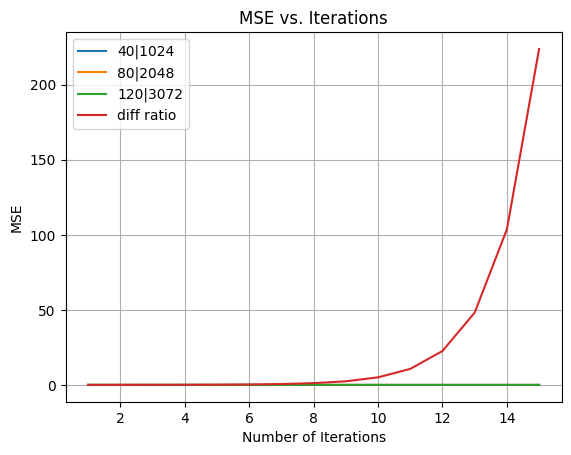

In [ ]:
plt.figure()
plt.plot(range(1,16), original, label='40|1024')
plt.plot(range(1,16), double_ratio, label='80|2048')
plt.plot(range(1,16), triple_ratio, label='120|3072')
plt.plot(range(1,16), diff_ratio, label='diff ratio')
plt.grid(True, which='both')
plt.legend()
plt.xlabel("Number of Iterations")
plt.title("MSE vs. Iterations")
plt.ylabel("MSE")
plt.show()

# Analyzing AMP

In [7]:
k = 40
N = 1024
n = 270

num_iterations = 15
num_avg = 1000
alpha = .25
threshold = .2 ## used for MD, FA

dual_bs = False
cmplx = True
fading = True
noise = True

snr_dB = 5   # enter an SNR in dB

SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)

In [ ]:
%%time
mse_iter1 = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(mse_iter1, separator=','))

[0.02773574,0.02462626,0.02113087,0.01866919,0.01680094,0.01523442,
 0.01406283,0.0130173 ,0.01221895,0.01148374,0.01088905,0.01036348,
 0.00992529,0.00953964,0.00919839]
CPU times: user 28min 9s, sys: 6min 47s, total: 34min 56s
Wall time: 20min 18s


k: 40
[0.02713906 0.02402911 0.02076779 0.01864146 0.01689968 0.01528756
 0.01405627 0.01295408 0.01216034 0.01142861 0.01093858 0.01045313
 0.01003107 0.00964496 0.00929783]
k: 60
[0.04335564 0.03970333 0.03529522 0.0321662  0.03001468 0.0280188
 0.02634732 0.02485942 0.02358415 0.02235138 0.02150452 0.02054985
 0.01963315 0.01898853 0.01847878]
k: 150
[0.11505732 0.11292423 0.10760234 0.10468322 0.10213046 0.10099302
 0.10068957 0.09925746 0.09931004 0.0981709  0.09685222 0.09550166
 0.09477308 0.09363114 0.09246046]
k: 300
[0.24946191 0.25578359 0.25810555 0.26045561 0.26234878 0.26384085
 0.26674233 0.26843197 0.26940607 0.26989396 0.27109801 0.27046598
 0.27051741 0.26986817 0.26943359]
k: 500
[0.42492096 0.44761944 0.4588718  0.47022767 0.4735753  0.47772293
 0.48354214 0.48622692 0.48769345 0.48894533 0.49125202 0.49150173
 0.48913579 0.4872033  0.48572318]
k: 800
[0.68747916 0.72981698 0.76275488 0.78359275 0.79421885 0.80685893
 0.82050812 0.82823126 0.83353275 0.8388678  0.84

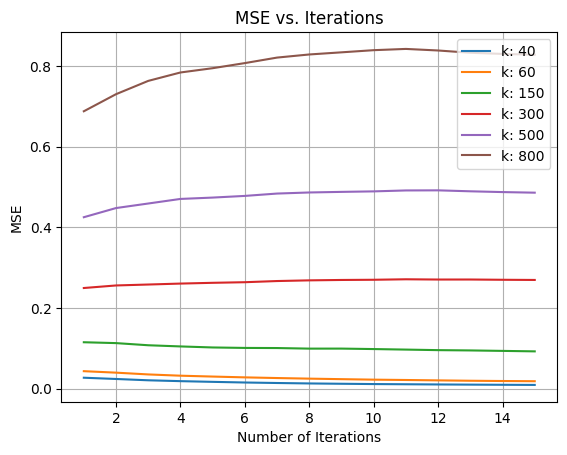

In [ ]:
plt.figure()
for k_val in [40, 60, 150, 300, 500, 800]:
  sys_param = (n,N,k_val,sigma)
  mse_iter1 = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
  plt.plot(range(1,num_iterations+1), mse_iter1, label=f'k: {k_val}')
  print(f'k: {k_val}\n{mse_iter1}')
plt.title("MSE vs. Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("MSE")
plt.grid(True, which='both')
plt.legend()
plt.show()

In [ ]:
dual_bs = False
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
mse_iter1 = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(mse_iter1, separator=','))

dual_bs = True
# finding the standard deviation of the noise
SNR = (10**(snr_dB/10))*2*n  ### adjusted for 2 BS SNR to be correct
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
mse_iter2 = amp_mse_iter(sys_param, tfs, num_iterations, num_avg)
print(np.array2string(mse_iter2, separator=','))

[0.02700255,0.02389578,0.02029273,0.01778949,0.01593606,0.01418927,
 0.013064  ,0.01205043,0.01132312,0.01068602,0.01012886,0.0096536 ,
 0.00927075,0.00890715,0.00858311,0.00830348,0.00807453,0.00783795,
 0.00763181,0.00744026,0.00726108,0.00708003,0.00690886,0.00675575,
 0.0066231 ,0.00650861,0.00641687,0.00633337,0.00624664,0.00617925]
[0.02616339,0.01902549,0.01458665,0.010872  ,0.00885263,0.00722443,
 0.0060773 ,0.00536453,0.00472008,0.00430803,0.00396595,0.00365164,
 0.00339479,0.00317866,0.00300247,0.0028345 ,0.00266786,0.00251237,
 0.00236134,0.00219184,0.00202719,0.00187727,0.00172547,0.00158672,
 0.00147026,0.00136299,0.00127534,0.00120755,0.00115334,0.00111265]


Noise: True | Fading: True | Dual BS: True | Complex: True
SNR: 5
Num_iter: 30
Averaged over 30 trials


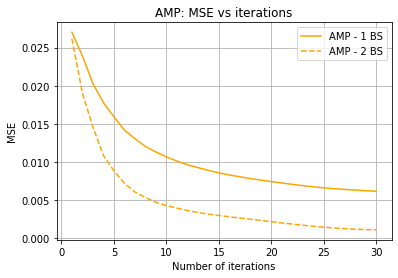

1 BS: [0.02700255 0.02389578 0.02029273 0.01778949 0.01593606 0.01418927
 0.013064   0.01205043 0.01132312 0.01068602 0.01012886 0.0096536
 0.00927075 0.00890715 0.00858311 0.00830348 0.00807453 0.00783795
 0.00763181 0.00744026 0.00726108 0.00708003 0.00690886 0.00675575
 0.0066231  0.00650861 0.00641687 0.00633337 0.00624664 0.00617925]
2 BS: [0.02616339 0.01902549 0.01458665 0.010872   0.00885263 0.00722443
 0.0060773  0.00536453 0.00472008 0.00430803 0.00396595 0.00365164
 0.00339479 0.00317866 0.00300247 0.0028345  0.00266786 0.00251237
 0.00236134 0.00219184 0.00202719 0.00187727 0.00172547 0.00158672
 0.00147026 0.00136299 0.00127534 0.00120755 0.00115334 0.00111265]


In [ ]:
print(f'Noise: {noise} | Fading: {fading} | Dual BS: {dual_bs} | Complex: {cmplx}')
if noise:
  print(f'SNR: {snr_dB}')

print(f'Num_iter: {num_iterations}')
print(f'Averaged over {num_avg} trials')
plt.figure()
plt.plot(range(1,num_iterations+1), abs(mse_iter1),label="AMP - 1 BS", color='orange')
if dual_bs:
  plt.plot(range(1,num_iterations+1), abs(mse_iter2),label="AMP - 2 BS", color='orange', linestyle='dashed')
plt.title("AMP: MSE vs iterations")
plt.xlabel("Number of iterations")
plt.ylabel("MSE")
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f'1 BS: {abs(mse_iter1)}')
if dual_bs:
  print(f'2 BS: {abs(mse_iter2)}')

MSE vs. SNR

In [ ]:
SNRdB = np.array([-12,-10, -5, 1, 5, 10, 20])
SNRs = (10**(SNRdB/10))*n
sigmas = 1/(np.sqrt(SNRs))

k: 40
[0.06988749 0.05030438 0.02457044 0.01163037 0.0095192  0.0077039
 0.00615159]
k: 60
[0.08850379 0.06501201 0.03649337 0.02381928 0.01808452 0.01697138
 0.01464847]
k: 150
[0.16303275 0.14601633 0.11672369 0.10547992 0.09983745 0.0974518
 0.09543035]
k: 300
[0.31695535 0.30694332 0.28030864 0.27107891 0.26921521 0.26776359
 0.26303782]
k: 500
[0.53154728 0.52390949 0.49639677 0.49714545 0.49115987 0.50701178
 0.49643725]
k: 800
[0.86872219 0.87306063 0.8332576  0.83585007 0.82419232 0.84871719
 0.85391547]
k: 1024
[1.13196906 1.13508365 1.08790061 1.10612472 1.06853772 1.07160086
 1.10797364]


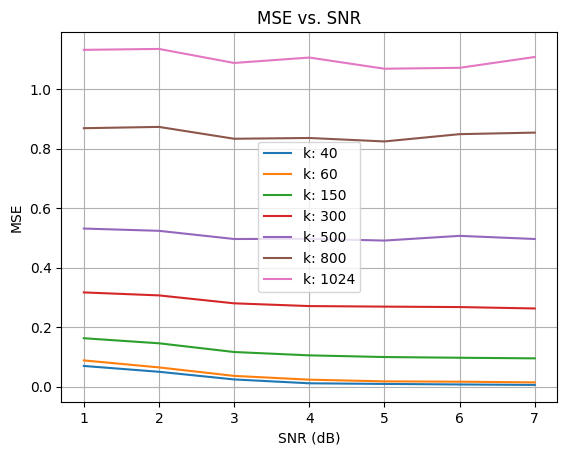

In [ ]:
plt.figure()
for k_val in [40, 60, 150, 300, 500, 800, 1024]:
  sys_param = (n,N,k_val,sigma)
  mse_iter1 = amp_mse_snr(sys_param, tfs, num_iterations, num_avg)
  plt.plot(range(1,len(mse_iter1)+1), mse_iter1, label=f'k: {k_val}')
  print(f'k: {k_val}\n{mse_iter1}')
plt.title("MSE vs. SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("MSE")
plt.grid(True, which='both')
plt.legend()
plt.show()

In [ ]:
dual_bs = False
tfs = (noise,fading,dual_bs,cmplx)
mse_snr1 = amp_mse_snr(sys_param, tfs, num_iterations, num_avg)

# comment the next three lines out if you don't want a dual_bs model
dual_bs = True
tfs = (noise,fading,dual_bs,cmplx)
mse_snr2 = amp_mse_snr(sys_param, tfs, num_iterations, num_avg)

Noise: True | Fading: True | Dual BS: True | Complex: True
Num_iter: 30
Averaged over 30 trials


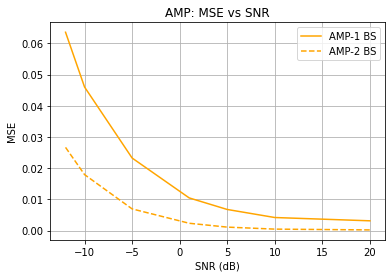

1 BS: [0.06356928 0.04601105 0.02326561 0.01048799 0.00678516 0.00420729
 0.003151  ]
2 BS: [0.02668073 0.01795216 0.00696462 0.00236634 0.00113199 0.00048959
 0.00023481]


In [ ]:
print(f'Noise: {noise} | Fading: {fading} | Dual BS: {dual_bs} | Complex: {cmplx}')

print(f'Num_iter: {num_iterations}')
print(f'Averaged over {num_avg} trials')
plt.figure()
plt.plot(SNRdB, abs(mse_snr1),label="AMP-1 BS", color='orange')
if dual_bs:
  plt.plot(SNRdB, abs(mse_snr2), label="AMP-2 BS", color='orange', linestyle='dashed')
plt.title("AMP: MSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("MSE")
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f'1 BS: {abs(mse_snr1)}')
if dual_bs:
  print(f'2 BS: {abs(mse_snr2)}')

MD, FA vs. Iterations

MD | k: 40
[32.1 17.8 14.  11.6 10.7  9.7  8.4  7.4  6.6  6.2  5.8  5.7  5.6  5.4
  5.1]
FA | k: 40
[0.2 5.4 4.1 2.5 1.8 1.7 1.2 0.5 0.5 0.5 0.4 0.2 0.2 0.  0. ]
MD | k: 60
[47.6 29.7 22.3 18.1 16.  15.  13.4 12.3 11.1 10.8 10.2  9.3  9.   8.5
  8.5]
FA | k: 60
[ 0.6 11.8 11.8 10.3  8.   7.9  6.1  5.2  3.5  2.8  2.2  1.6  1.8  1.1
  1. ]
MD | k: 150
[122.   86.4  75.8  74.8  72.   70.3  68.5  68.1  67.7  67.3  65.3  65.7
  65.1  63.7  63. ]
FA | k: 150
[ 9.3 52.4 55.4 58.1 55.5 57.4 57.  55.  53.4 53.  53.3 57.8 57.6 57.2
 54.8]
MD | k: 300
[254.  204.2 191.  190.3 189.2 183.9 181.2 184.5 185.6 186.1 183.7 184.7
 185.4 187.6 185. ]
FA | k: 300
[ 21.9  75.7  84.   84.7  88.4  95.   95.6  96.   91.8  94.   96.9 101.3
 100.7  97.   96.4]
MD | k: 500
[423.7 355.3 340.6 340.1 339.7 336.3 336.  335.3 331.9 329.5 331.4 332.8
 334.4 333.  333.6]
FA | k: 500
[ 29.1  69.7  73.8  79.8  84.7  88.5  89.5  94.7  98.2  98.6 100.5  98.3
  96.1  97.4  97.4]
MD | k: 800
[674.2 587.3 565.5 566.2 560.  55

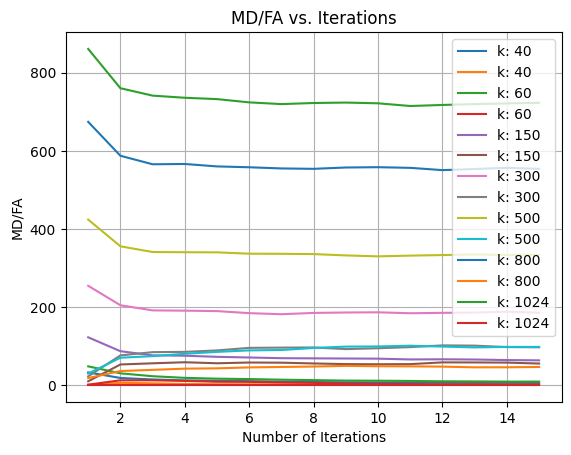

In [ ]:
plt.figure()
for k_val in [40, 60, 150, 300, 500, 800, 1024]:
  sys_param = (n,N,k_val,sigma)
  md_iter1, fa_iter1 = amp_md_fa_iter(sys_param, tfs, num_iterations, num_avg, threshold)
  plt.plot(range(1,len(md_iter1)+1), md_iter1, label=f'k: {k_val}')
  print(f'MD | k: {k_val}\n{md_iter1}')
  plt.plot(range(1,len(fa_iter1)+1), fa_iter1, label=f'k: {k_val}')
  print(f'FA | k: {k_val}\n{fa_iter1}')
plt.title("MD/FA vs. Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("MD/FA")
plt.grid(True, which='both')
plt.legend()
plt.show()

In [ ]:
dual_bs = False
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
md_iter1, fa_iter1 = amp_md_fa_iter(sys_param, tfs, num_iterations, num_avg, threshold)

dual_bs = True
SNR = (10**(snr_dB/10))*2*n  ### adjusted for 2 BS SNR to be correct
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
md_iter2, fa_iter2 = amp_md_fa_iter(sys_param, tfs, num_iterations, num_avg, threshold)

In [ ]:
print("15 iter. 100 avg.")
print("1 BS AMP:")
print(f'FA: {fa_iter1}')
print(f'MD: {md_iter1}')

print('*****************')
print("2 BS AMP:")
print(f'FA: {fa_iter2}')
print(f'MD: {md_iter2}')

15 iter. 100 avg.
1 BS AMP:
FA: [13.09  63.073 61.556 54.966 47.002 41.089 36.724 31.643 27.408 23.582
 20.937 18.415 16.236 14.13  12.564]
MD: [19.772 11.753  9.342  8.008  7.108  6.503  6.004  5.601  5.231  4.946
  4.712  4.502  4.322  4.178  4.063]
*****************
2 BS AMP:
FA: [ 4.029 43.536 48.012 33.947 26.14  18.477 13.964 10.789  8.745  7.642
  6.697  6.055  5.534  5.132  4.646]
MD: [18.264  6.597  3.604  2.289  1.539  1.12   0.862  0.668  0.517  0.417
  0.342  0.293  0.26   0.239  0.213]


Noise: True | Fading: True | Dual BS: True | Complex: True
SNR: 5
Num_iter: 30 | Avg: 30
Threshold: 0.4


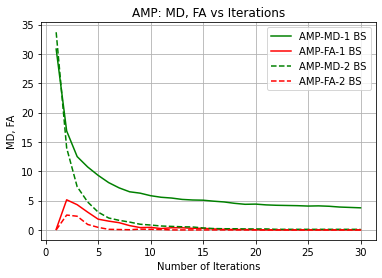

MD-1 BS: [30.83333333 16.86666667 12.5        10.73333333  9.3         8.06666667
  7.16666667  6.5         6.26666667  5.83333333  5.56666667  5.43333333
  5.2         5.1         5.06666667  4.9         4.76666667  4.53333333
  4.36666667  4.4         4.26666667  4.2         4.16666667  4.13333333
  4.06666667  4.1         4.03333333  3.9         3.83333333  3.76666667]
FA-1 BS: [0.1        5.13333333 4.3        3.03333333 1.83333333 1.5
 1.23333333 0.73333333 0.4        0.43333333 0.23333333 0.36666667
 0.36666667 0.26666667 0.26666667 0.16666667 0.1        0.06666667
 0.06666667 0.03333333 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
MD-2 BS: [33.7        13.96666667  7.36666667  4.76666667  3.03333333  2.03333333
  1.63333333  1.33333333  0.96666667  0.83333333  0.66666667  0.6
  0.53333333  0.5         0.33333333  0.23333333  0.2         0.2
  0.16666667  0.16666667  0.16666667  0.1         0.1         0.1
  0.1         0

In [ ]:
print(f'Noise: {noise} | Fading: {fading} | Dual BS: {dual_bs} | Complex: {cmplx}')
if noise:
  print(f'SNR: {snr_dB}')

print(f'Num_iter: {num_iterations} | Avg: {num_avg}')
print(f'Threshold: {threshold}')
plt.figure()
plt.plot(range(1,num_iterations+1), abs(md_iter1),label="AMP-MD-1 BS", color='green')
plt.plot(range(1,num_iterations+1), abs(fa_iter1),label="AMP-FA-1 BS", color='red')
if dual_bs:
  plt.plot(range(1,num_iterations+1), abs(md_iter2),label="AMP-MD-2 BS", color='green', linestyle='dashed')
  plt.plot(range(1,num_iterations+1), abs(fa_iter2),label="AMP-FA-2 BS", color='red', linestyle='dashed')
plt.title("AMP: MD, FA vs Iterations")
plt.xlabel("Number of Iterations")
plt.ylabel("MD, FA")
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f'MD-1 BS: {abs(md_iter1)}')
print(f'FA-1 BS: {abs(fa_iter1)}')
if dual_bs:
  print(f'MD-2 BS: {abs(md_iter2)}')
  print(f'FA-2 BS: {abs(fa_iter2)}')

MD, FA vs. SNR

In [ ]:
dual_bs = False
SNR = (10**(snr_dB/10))*n
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
md_snr1, fa_snr1 = amp_md_fa_snr(sys_param, tfs, num_iterations, num_avg, threshold)

dual_bs = True
SNR = (10**(snr_dB/10))*n*2
sigma = 1/(np.sqrt(SNR))
sys_param = (n,N,k,sigma)
tfs = (noise,fading,dual_bs,cmplx)
md_snr2, fa_snr2 = amp_md_fa_snr(sys_param, tfs, num_iterations, num_avg, threshold)

In [ ]:
print("15 iter. 100 avg.")
print("1 BS AMP:")
print(f'FA: {fa_snr1}')
print(f'MD: {md_snr1}')

print('*****************')
print("2 BS AMP:")
print(f'FA: {fa_snr2}')
print(f'MD: {md_snr2}')

15 iter. 100 avg.
1 BS AMP:
FA: [1.0085e+02 6.8540e+01 1.4280e+01 6.8000e-01 6.0000e-02 2.0000e-02
 0.0000e+00]
MD: [19.32 16.09 10.23  6.43  5.32  4.9   4.81]
*****************
2 BS AMP:
FA: [4.022e+01 2.131e+01 3.330e+00 3.000e-01 2.000e-02 0.000e+00 0.000e+00]
MD: [11.59  7.89  1.93  0.74  0.34  0.26  0.29]


Noise: True | Fading: True | Dual BS: True | Complex: True
Num_iter: 15 | Avg: 1
Threshold: 0.4


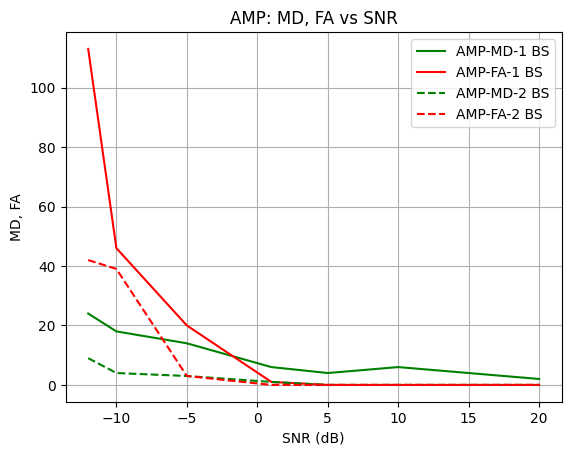

MD-1 BS: [24. 18. 14.  6.  4.  6.  2.]
FA-1 BS: [113.  46.  20.   1.   0.   0.   0.]
MD-2 BS: [9. 4. 3. 1. 0. 0. 0.]
FA-2 BS: [42. 39.  3.  0.  0.  0.  0.]


In [ ]:
print(f'Noise: {noise} | Fading: {fading} | Dual BS: {dual_bs} | Complex: {cmplx}')
SNRdB = [-12,-10,-5,1,5,10,20]
print(f'Num_iter: {num_iterations} | Avg: {num_avg}')
print(f'Threshold: {threshold}')
plt.figure()
plt.plot(SNRdB, abs(md_snr1),label="AMP-MD-1 BS", color='green')
plt.plot(SNRdB, abs(fa_snr1),label="AMP-FA-1 BS", color='red')
if dual_bs:
  plt.plot(SNRdB, abs(md_snr2),label="AMP-MD-2 BS", color='green', linestyle='dashed')
  plt.plot(SNRdB, abs(fa_snr2),label="AMP-FA-2 BS", color='red', linestyle='dashed')
plt.title("AMP: MD, FA vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("MD, FA")
plt.legend()
plt.grid(True, which='both')
plt.show()

print(f'MD-1 BS: {abs(md_snr1)}')
print(f'FA-1 BS: {abs(fa_snr1)}')
if dual_bs:
  print(f'MD-2 BS: {abs(md_snr2)}')
  print(f'FA-2 BS: {abs(fa_snr2)}')